# ARIMAX Model to Predict DJIA Movement using Financial Indicators

In [1]:
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
indicators = pd.read_csv('indicators.csv')

In [3]:
indicators = indicators.set_index('date')

In [4]:
indicators = indicators.iloc[:, 1:16]

In [5]:
indicators = indicators.drop(['MACD_Signal', 'MACD', 'SlowD','SlowK', 'Chaikin A/D', 'OBV', 'Real Lower Band', 'Real Upper Band', 'Real Middle Band'], axis=1)

In [6]:
indicators.head()

EMA  MACD_Hist      ADX       CCI  Aroon Up  Aroon Down
date                                                                      
2008-08-08  11476.3169    57.9608  27.4966  108.0829     100.0        10.0
2008-08-11  11505.4629    65.8362  26.1700  163.4895     100.0         5.0
2008-08-12  11518.5111    58.8868  25.0124  113.4722      95.0         0.0
2008-08-13  11519.8872    44.8138  24.2850   34.3782      90.0         0.0
2008-08-14  11529.0341    39.1951  23.3506   61.5287      85.0        35.0

In [7]:
indicators = indicators.shift(-1)

In [8]:
indicators = indicators[:-1]

In [9]:
indicators

EMA  MACD_Hist      ADX       CCI  Aroon Up  Aroon Down
date                                                                      
2008-08-08  11505.4629    65.8362  26.1700  163.4895     100.0         5.0
2008-08-11  11518.5111    58.8868  25.0124  113.4722      95.0         0.0
2008-08-12  11519.8872    44.8138  24.2850   34.3782      90.0         0.0
2008-08-13  11529.0341    39.1951  23.3506   61.5287      85.0        35.0
2008-08-14  11541.4976    36.5917  22.4629   89.2400      80.0        30.0
2008-08-15  11535.5825    21.6055  22.0318   16.3283      75.0        25.0
2008-08-18  11517.7699     2.7641  21.8819  -65.4311      70.0        20.0
2008-08-19  11508.2137    -4.7664  21.8007  -55.4039      65.0        15.0
2008-08-20  11500.7848    -8.3822  21.6489  -42.6154      60.0        10.0
2008-08-21  11512.9062     2.4752  21.0032   38.2532      55.0         5.0
2008-08-22  11500.8437    -6.2289  20.5509  -30.9690      50.0         0.0
2008-08-25  11492.4652    -9.5925  20.1771  -76.6398      45.0         0.0
2008-08-26  11493.4219    -5.3890  19.4465  -19.5434      40.0        15.0
2008-08-27  11514.5417    11.2008  18.6540   79.7029      35.0        10.0
2008-08-28  11517.3434    10.1601  17.9011   46.4002      30.0         5.0
2008-08-29  11517.3031     7.3015  17.3980   34.8383      25.0         0.0
2008-09-02  11518.7866     6.1809  16.7462  -34.5264      20.0         0.0
2008-09-03  11487.3050   -16.8191  16.3616 -160.2497      15.0       100.0
2008-09-04  11461.9388   -28.2051  16.3243 -201.0235      10.0       100.0
2008-09-05  11466.5866   -15.2461  15.6045  -40.7507       5.0        95.0
2008-09-08  11444.1241   -24.0354  14.9370  -85.1104       0.0        90.0
2008-09-09  11427.4380   -25.6339  14.2626 -109.4244      70.0        85.0
2008-09-10  11428.0353   -14.5038  13.7762  -77.3695      65.0        80.0
2008-09-11  11427.4596    -7.2104  13.2749  -35.1877      60.0        75.0
2008-09-12  11378.8929   -34.1346  13.6069 -203.3931      55.0       100.0
2008-09-15  11348.4288   -39.7908  14.2367 -228.6659      50.0       100.0
2008-09-16  11278.0699   -69.4375  15.0743 -249.5450      45.0       100.0
2008-09-17  11253.4623   -57.5642  16.0761 -168.3713      40.0       100.0
2008-09-18  11266.3174   -22.7927  15.9624   -8.0624      35.0        95.0
2008-09-19  11242.4481   -22.7606  15.9142  -59.5986      30.0        90.0
...                ...        ...      ...       ...       ...         ...
2016-05-20  17652.1205   -43.7916  11.5551 -105.7396      10.0        90.0
2016-05-23  17657.2567   -24.8209  10.9840  -19.7215       5.0        85.0
2016-05-24  17675.7570    -2.1532  10.9222   93.2521       0.0        80.0
2016-05-25  17690.2839    10.8836  10.8636  106.3813       0.0        75.0
2016-05-26  17707.7064    21.5251  10.8078  107.9454      35.0        70.0
2016-05-27  17715.2772    21.7012  10.3680   78.1243      30.0        65.0
2016-05-31  17722.3622    20.9065   9.9624   47.1224      25.0        60.0
2016-06-01  17733.4287    22.4597   9.4677   65.5914      20.0        55.0
2016-06-02  17740.4413    20.2216   9.0503   50.3686      15.0        50.0
2016-06-03  17757.5735    24.9172   8.9716  109.4250     100.0        45.0
2016-06-06  17774.7836    27.5727   9.0796  126.9975     100.0        40.0
2016-06-07  17796.7138    31.8632   9.2258  131.3209     100.0        35.0
2016-06-08  17814.6639    31.3522   9.2930  111.7136      95.0        30.0
2016-06-09  17819.4902    21.4061   8.9140   60.5769      90.0        25.0
2016-06-10  17811.2035     5.1885   8.6974   17.7668      85.0        20.0
2016-06-13  17798.2146    -9.3225   8.9606  -38.8833      80.0        15.0
2016-06-14  17783.1628   -20.5135   9.0870  -39.1319      75.0        10.0
2016-06-15  17778.3948   -20.8483   9.6953  -58.0219      70.0         5.0
2016-06-16  17768.5630   -23.9417  10.2732  -62.6317      65.0         0.0
2016-06-17  17772.0207   -16.5722   9.9635   28.1692      60.0         0.0
2016-06-20  17777.5169    -9.6843   9.6694  

Text(0.5, 1.0, 'Heatmap of Correlation between Features')

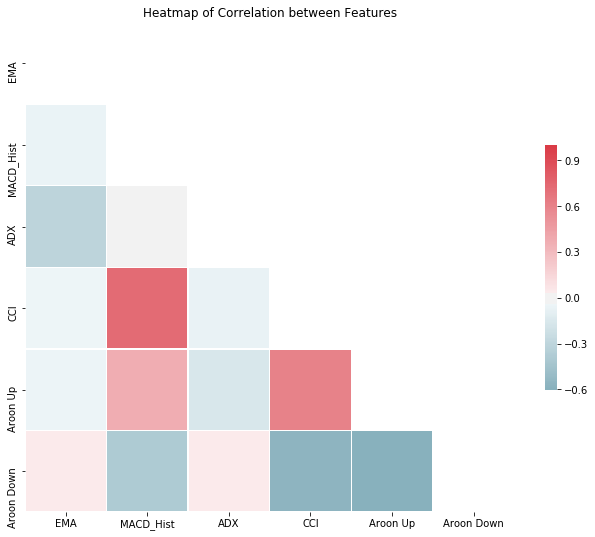

In [10]:
import numpy as np
import seaborn as sns
#Features to remove from the plot:
corr = indicators.corr() 
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap of Correlation between Features')

In [11]:
#Set Index Datetime
def equalizestock(time):
#     time.index = pd.to_datetime(time.index)
    if time.index.name != 'date':
        time = time.set_index('date')
        time = time.loc['2008-08-07':'2016-07-01']
        return time
    else:
        time = time.loc['2008-08-07':'2016-07-01']
        return time

In [89]:
ts = TimeSeries(key='X5AYBIDIH2EVGNW9', output_format='pandas')
stock, meta_data = ts.get_daily(symbol='DJIA', outputsize='full')
stock = stock['4. close']
stock = pd.DataFrame({'date':stock.index, 'close':stock.values})
stock.head()

date       close
0  2000-01-03  11357.5098
1  2000-01-04  10997.9297
2  2000-01-05  11122.6504
3  2000-01-06  11253.2598
4  2000-01-07  11522.5596

In [90]:
stock = equalizestock(stock)

In [91]:
stock.tail()

close
date                  
2016-06-27  17140.2402
2016-06-28  17409.7207
2016-06-29  17694.6797
2016-06-30  17929.9902
2016-07-01  17949.3691

In [92]:
#save file for web app
stock.to_csv(r'/Users/flatironschool/Final Project/djiastockprice.csv')

In [23]:
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv")

closing = go.Scatter(
                x=stock.index,
                y=stock['close'],
                name = "price",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

data = [closing]

layout = dict(
    title = "DJIA Price",
    xaxis = dict(
        range = ['2008-08-07','2016-07-01'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "DJIA Price")

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [24]:
stock = stock.pct_change()

In [25]:
stock = stock.dropna()
stock.head()

close
date                
2008-08-08  0.026496
2008-08-11  0.004093
2008-08-12 -0.011872
2008-08-13 -0.009406
2008-08-14  0.007194

In [26]:
endogenous_train = stock[:-80]
exogenous_train = indicators[:-80]
endogenous_test = stock[-80:]
exogenous_test = indicators[-80:]

In [27]:
len(indicators)

1989

Text(0, 0.5, 'Dow Jones price')

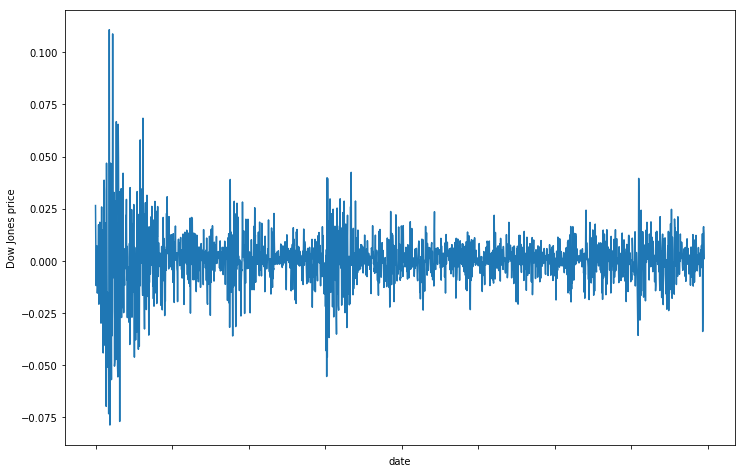

In [28]:
fig = plt.figure(figsize=(12, 8))
stock['close'].plot()
plt.ylabel("Dow Jones price")

In [239]:
from calendar import Calendar

In [29]:
df = pd.date_range(start='08/07/2008', end='07/01/2016')
df = pd.DataFrame(df)

In [30]:
df.columns = ['date']
df['weekday'] = df['date'].dt.dayofweek
df = df[df['weekday'] < 5]

In [31]:
df = df.set_index(df['date'])

In [32]:
df = df.drop(['date'], axis=1)

In [33]:
df

weekday
date               
2008-08-07        3
2008-08-08        4
2008-08-11        0
2008-08-12        1
2008-08-13        2
2008-08-14        3
2008-08-15        4
2008-08-18        0
2008-08-19        1
2008-08-20        2
2008-08-21        3
2008-08-22        4
2008-08-25        0
2008-08-26        1
2008-08-27        2
2008-08-28        3
2008-08-29        4
2008-09-01        0
2008-09-02        1
2008-09-03        2
2008-09-04        3
2008-09-05        4
2008-09-08        0
2008-09-09        1
2008-09-10        2
2008-09-11        3
2008-09-12        4
2008-09-15        0
2008-09-16        1
2008-09-17        2
...             ...
2016-05-23        0
2016-05-24        1
2016-05-25        2
2016-05-26        3
2016-05-27        4
2016-05-30        0
2016-05-31        1
2016-06-01        2
2016-06-02        3
2016-06-03        4
2016-06-06        0
2016-06-07        1
2016-06-08        2
2016-06-09        3
2016-06-10        4
2016-06-13        0
2016-06-14        1
2016-06-15        2
2016-06-16        3
2016-06-17        4
2016-06-20        0
2016-06-21        1
2016-06-22        2
2016-06-23        3
2016-06-24        4
2016-06-27        0
2016-06-28        1
2016-06-29        2
2016-06-30        3
2016-07-01        4

[2062 rows x 1 columns]

In [34]:
df.index = df.index.strftime("%Y-%m-%d")

In [35]:
df.index[0]

'2008-08-07'

In [50]:
result = pd.concat([stock, df], axis=1, sort=False)
result = result.sort_index()

In [51]:
result = result.bfill()

In [52]:
grouped_df = result.groupby(['weekday'])

for key, item in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

               close  weekday
2008-08-11  0.004093        0
2008-08-18 -0.015481        0
2008-08-25 -0.020795        0
2008-09-01 -0.002342        0
2008-09-08  0.025825        0
2008-09-15 -0.044167        0
2008-09-22 -0.032731        0
2008-09-29 -0.069790        0
2008-10-06 -0.035822        0
2008-10-13  0.110803        0
2008-10-20  0.046679        0
2008-10-27 -0.024249        0
2008-11-03 -0.000555        0
2008-11-10 -0.008192        0
2008-11-17 -0.026329        0
2008-11-24  0.049335        0
2008-12-01 -0.077013        0
2008-12-08  0.034597        0
2008-12-15 -0.007549        0
2008-12-22 -0.006926        0
2008-12-29 -0.003713        0
2009-01-05 -0.009054        0
2009-01-12 -0.014561        0
2009-01-19 -0.040106        0
2009-01-26  0.004763        0
2009-02-02 -0.008013        0
2009-02-09 -0.001174        0
2009-02-16 -0.037936        0
2009-02-23 -0.034062        0
2009-03-02 -0.042424        0
...              ...      ...
2015-12-07 -0.006562        0
2015-12-14

In [53]:
mon = grouped_df.get_group(0)['close'].values
tue = grouped_df.get_group(1)['close'].values
wed = grouped_df.get_group(2)['close'].values
thu = grouped_df.get_group(3)['close'].values
fri = grouped_df.get_group(4)['close'].values

In [54]:
import scipy.stats as stats

In [55]:
stats.f_oneway(mon, tue, wed, thu, fri)

F_onewayResult(statistic=0.7444693586608578, pvalue=0.5616531682099104)

In [56]:
result = result.drop(['weekday'], axis=1)

In [57]:
result

close
2008-08-07  0.026496
2008-08-08  0.026496
2008-08-11  0.004093
2008-08-12 -0.011872
2008-08-13 -0.009406
2008-08-14  0.007194
2008-08-15  0.003785
2008-08-18 -0.015481
2008-08-19 -0.011398
2008-08-20  0.006069
2008-08-21  0.001119
2008-08-22  0.017309
2008-08-25 -0.020795
2008-08-26  0.002338
2008-08-27  0.007854
2008-08-28  0.018489
2008-08-29 -0.014615
2008-09-01 -0.002342
2008-09-02 -0.002342
2008-09-03  0.001386
2008-09-04 -0.029884
2008-09-05  0.002925
2008-09-08  0.025825
2008-09-09 -0.024326
2008-09-10  0.003400
2008-09-11  0.014623
2008-09-12 -0.001025
2008-09-15 -0.044167
2008-09-16  0.012962
2008-09-17 -0.040633
...              ...
2016-05-23 -0.000458
2016-05-24  0.012183
2016-05-25  0.008215
2016-05-26 -0.001301
2016-05-27  0.002520
2016-05-30 -0.004813
2016-05-31 -0.004813
2016-06-01  0.000139
2016-06-02  0.002748
2016-06-03 -0.001766
2016-06-06  0.006361
2016-06-07  0.001002
2016-06-08  0.003722
2016-06-09 -0.001103
2016-06-10 -0.006664
2016-06-13 -0.007437
2016-06-14 -0.003252
2016-06-15 -0.001960
2016-06-16  0.005268
2016-06-17 -0.003267
2016-06-20  0.007338
2016-06-21  0.001396
2016-06-22 -0.002743
2016-06-23  0.012949
2016-06-24 -0.033886
2016-06-27 -0.014971
2016-06-28  0.015722
2016-06-29  0.016368
2016-06-30  0.013298
2016-07-01  0.001081

[2062 rows x 1 columns]

In [58]:
ts = result['close']
ts.head()

2008-08-07    0.026496
2008-08-08    0.026496
2008-08-11    0.004093
2008-08-12   -0.011872
2008-08-13   -0.009406
Name: close, dtype: float64

In [59]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     rolmean = pd.rolling(timeseries, window=12)
    rolmean = timeseries.rolling(window=12).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

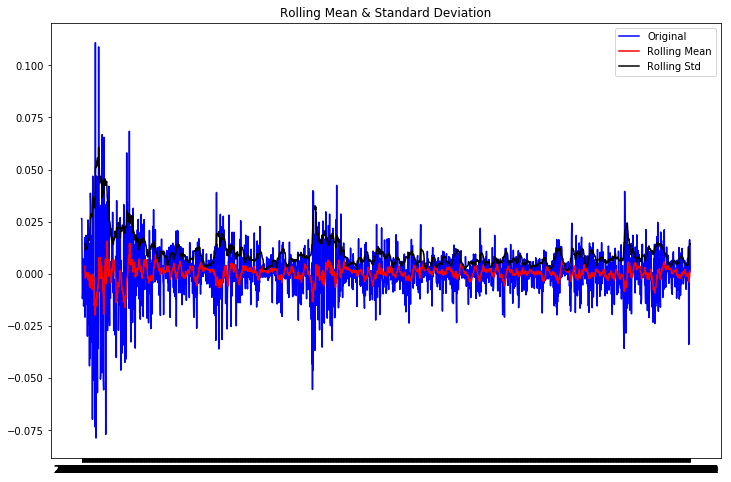

Results of Dickey-Fuller Test:
Test Statistic                -1.166758e+01
p-value                        1.868044e-21
#Lags Used                     1.700000e+01
Number of Observations Used    2.044000e+03
Critical Value (1%)           -3.433553e+00
Critical Value (5%)           -2.862955e+00
Critical Value (10%)          -2.567523e+00
dtype: float64


In [60]:
test_stationarity(ts)

## Forecasting

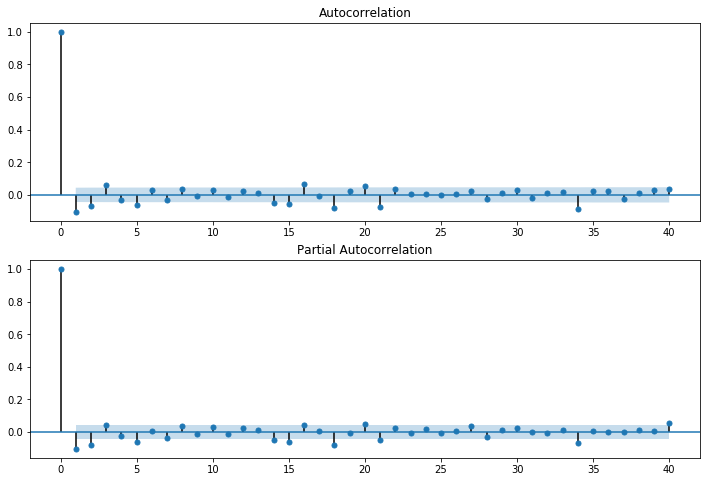

In [62]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure(figsize = (12,8))
pyplot.subplot(211)
plot_acf(stock, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(stock, ax=pyplot.gca(), lags=40)
pyplot.show()

In [63]:
from statsmodels.tsa.arima_model import ARIMA

In [64]:
# fit model
mod = ARIMA(endogenous_train, order=(0,0,2), exog = exogenous_train)
results = mod.fit()
print(results.summary())

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1909
Model:                     ARMA(0, 2)   Log Likelihood                5840.084
Method:                       css-mle   S.D. of innovations              0.011
Date:                Wed, 06 Feb 2019   AIC                         -11660.168
Time:                        23:27:40   BIC                         -11604.625
Sample:                             0   HQIC                        -11639.726
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0014      0.000     12.226      0.000       0.001       0.002
EMA          -5.91e-08        nan        nan        nan         nan         nan
MACD_Hist    1.424e-06   5.85e-06      0.243    

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning:

invalid value encountered in sqrt

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning:

invalid value encountered in less_equal



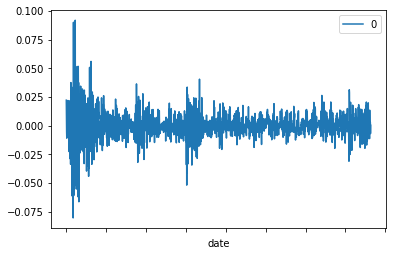

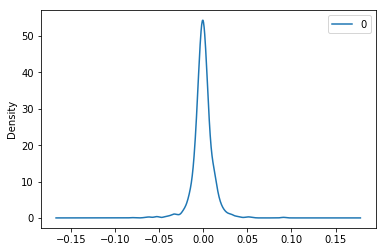

                 0
count  1909.000000
mean      0.000028
std       0.011358
min      -0.080444
25%      -0.004927
50%      -0.000107
75%       0.004694
max       0.091954


In [65]:
# plot residual errors
residuals = pd.DataFrame(results.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [66]:
endogenous_test.index[0]

'2016-03-10'

In [67]:
endogenous_test.index[-1]

'2016-07-01'

In [68]:
endogenous_test.head()

close
date                
2016-03-10 -0.000308
2016-03-11  0.012838
2016-03-14  0.000919
2016-03-15  0.001300
2016-03-16  0.004303

In [69]:
date = endogenous_test

In [70]:
date = date.reset_index()

In [71]:
date

date     close
0   2016-03-10 -0.000308
1   2016-03-11  0.012838
2   2016-03-14  0.000919
3   2016-03-15  0.001300
4   2016-03-16  0.004303
5   2016-03-17  0.008988
6   2016-03-18  0.006911
7   2016-03-21  0.001225
8   2016-03-22 -0.002343
9   2016-03-23 -0.004549
10  2016-03-24  0.000751
11  2016-03-28  0.001122
12  2016-03-29  0.005573
13  2016-03-30  0.004738
14  2016-03-31 -0.001782
15  2016-04-01  0.006088
16  2016-04-04 -0.003133
17  2016-04-05 -0.007537
18  2016-04-06  0.006404
19  2016-04-07 -0.009827
20  2016-04-08  0.001995
21  2016-04-11 -0.001169
22  2016-04-12  0.009389
23  2016-04-13  0.010554
24  2016-04-14  0.001014
25  2016-04-15 -0.001616
26  2016-04-18  0.005962
27  2016-04-19  0.002746
28  2016-04-20  0.002364
29  2016-04-21 -0.006286
..         ...       ...
50  2016-05-20  0.003759
51  2016-05-23 -0.000458
52  2016-05-24  0.012183
53  2016-05-25  0.008215
54  2016-05-26 -0.001301
55  2016-05-27  0.002520
56  2016-05-31 -0.004813
57  2016-06-01  0.000139
58  2016-06-02  0.002748
59  2016-06-03 -0.001766
60  2016-06-06  0.006361
61  2016-06-07  0.001002
62  2016-06-08  0.003722
63  2016-06-09 -0.001103
64  2016-06-10 -0.006664
65  2016-06-13 -0.007437
66  2016-06-14 -0.003252
67  2016-06-15 -0.001960
68  2016-06-16  0.005268
69  2016-06-17 -0.003267
70  2016-06-20  0.007338
71  2016-06-21  0.001396
72  2016-06-22 -0.002743
73  2016-06-23  0.012949
74  2016-06-24 -0.033886
75  2016-06-27 -0.014971
76  2016-06-28  0.015722
77  2016-06-29  0.016368
78  2016-06-30  0.013298
79  2016-07-01  0.001081

[80 rows x 2 columns]

In [72]:
len(endogenous_train)

1909

In [73]:
predicted = pd.DataFrame(results.predict(start = 1909,
                                    end = 1988,
                                    exog = exogenous_test,
                                    dynamic = True))
predicted

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



0
1909  0.002251
1910  0.001769
1911  0.001392
1912  0.002676
1913  0.003499
1914  0.004249
1915  0.003718
1916  0.002356
1917  0.000962
1918  0.000139
1919  0.000853
1920  0.000903
1921  0.001240
1922  0.000747
1923  0.000318
1924  0.001311
1925 -0.000551
1926 -0.000273
1927 -0.002033
1928 -0.001680
1929 -0.001338
1930  0.000713
1931  0.004842
1932  0.005888
1933  0.003918
1934  0.004497
1935  0.005086
1936  0.004379
1937  0.001601
1938  0.000205
...        ...
1959 -0.002118
1960  0.002324
1961  0.008133
1962  0.008627
1963  0.006742
1964  0.005303
1965  0.003802
1966  0.004804
1967  0.004099
1968  0.002553
1969  0.003257
1970  0.003294
1971  0.002370
1972 -0.000161
1973 -0.002279
1974 -0.005093
1975 -0.005051
1976 -0.005936
1977 -0.006103
1978 -0.001248
1979  0.002022
1980  0.001293
1981  0.006622
1982 -0.006696
1983 -0.013722
1984 -0.006979
1985 -0.000213
1986  0.004932
1987  0.006745
1988  0.004615

[80 rows x 1 columns]

In [74]:
predicted = predicted.set_index(date['date'])

In [75]:
predicted.columns = ['predicted']

In [76]:
len(predicted)

80

In [77]:
endogenous_test.head()

close
date                
2016-03-10 -0.000308
2016-03-11  0.012838
2016-03-14  0.000919
2016-03-15  0.001300
2016-03-16  0.004303

In [78]:
con_resid = pd.concat([predicted, endogenous_test], axis=1, sort=False)

In [79]:
con_resid

predicted     close
date                           
2016-03-10   0.002251 -0.000308
2016-03-11   0.001769  0.012838
2016-03-14   0.001392  0.000919
2016-03-15   0.002676  0.001300
2016-03-16   0.003499  0.004303
2016-03-17   0.004249  0.008988
2016-03-18   0.003718  0.006911
2016-03-21   0.002356  0.001225
2016-03-22   0.000962 -0.002343
2016-03-23   0.000139 -0.004549
2016-03-24   0.000853  0.000751
2016-03-28   0.000903  0.001122
2016-03-29   0.001240  0.005573
2016-03-30   0.000747  0.004738
2016-03-31   0.000318 -0.001782
2016-04-01   0.001311  0.006088
2016-04-04  -0.000551 -0.003133
2016-04-05  -0.000273 -0.007537
2016-04-06  -0.002033  0.006404
2016-04-07  -0.001680 -0.009827
2016-04-08  -0.001338  0.001995
2016-04-11   0.000713 -0.001169
2016-04-12   0.004842  0.009389
2016-04-13   0.005888  0.010554
2016-04-14   0.003918  0.001014
2016-04-15   0.004497 -0.001616
2016-04-18   0.005086  0.005962
2016-04-19   0.004379  0.002746
2016-04-20   0.001601  0.002364
2016-04-21   0.000205 -0.006286
...               ...       ...
2016-05-20  -0.002118  0.003759
2016-05-23   0.002324 -0.000458
2016-05-24   0.008133  0.012183
2016-05-25   0.008627  0.008215
2016-05-26   0.006742 -0.001301
2016-05-27   0.005303  0.002520
2016-05-31   0.003802 -0.004813
2016-06-01   0.004804  0.000139
2016-06-02   0.004099  0.002748
2016-06-03   0.002553 -0.001766
2016-06-06   0.003257  0.006361
2016-06-07   0.003294  0.001002
2016-06-08   0.002370  0.003722
2016-06-09  -0.000161 -0.001103
2016-06-10  -0.002279 -0.006664
2016-06-13  -0.005093 -0.007437
2016-06-14  -0.005051 -0.003252
2016-06-15  -0.005936 -0.001960
2016-06-16  -0.006103  0.005268
2016-06-17  -0.001248 -0.003267
2016-06-20   0.002022  0.007338
2016-06-21   0.001293  0.001396
2016-06-22   0.006622 -0.002743
2016-06-23  -0.006696  0.012949
2016-06-24  -0.013722 -0.033886
2016-06-27  -0.006979 -0.014971
2016-06-28  -0.000213  0.015722
2016-06-29   0.004932  0.016368
2016-06-30   0.006745  0.013298
2016-07-01   0.004615  0.001081

[80 rows x 2 columns]

In [80]:
from sklearn.metrics import mean_absolute_error
RMSE = mean_absolute_error(con_resid['close'], con_resid['predicted'])**0.5

In [81]:
RMSE

0.07034469683139245

In [841]:
resid_pred = pd.read_csv('resid_pred.csv')

In [842]:
resid_pred = pd.DataFrame(resid_pred['Resid Pred'])

In [843]:
resid_pred = resid_pred.set_index(date['date'])

In [844]:
resid_pred.head()

Resid Pred
date                  
2016-03-10   -0.001484
2016-03-11   -0.002753
2016-03-14   -0.001641
2016-03-15    0.003280
2016-03-16    0.001419

In [845]:
resid_pred['Resid Pred'].mean()

-0.004610381205375

In [846]:
true_resid = pd.concat([resid_pred, endogenous_test], axis=1, sort=False)

In [847]:
true_resid.head()

Resid Pred     close
date                            
2016-03-10   -0.001484 -0.000308
2016-03-11   -0.002753  0.012838
2016-03-14   -0.001641  0.000919
2016-03-15    0.003280  0.001300
2016-03-16    0.001419  0.004303

In [848]:
from sklearn.metrics import mean_absolute_error
RMSE = mean_absolute_error(true_resid['close'], true_resid['Resid Pred'])**0.5

In [849]:
RMSE

0.08937345663310292

In [850]:
true_resid['Resid Pred'] = true_resid['Resid Pred'] + con_resid['predicted']

In [863]:
true_resid.head()

Resid Pred  close
date                         
2016-03-10           1      0
2016-03-11           0      1
2016-03-14           0      1
2016-03-15           1      1
2016-03-16           1      1

In [852]:
from sklearn.metrics import mean_absolute_error
RMSE = mean_absolute_error(true_resid['close'], true_resid['Resid Pred'])**0.5

In [853]:
RMSE

0.08535193639684112

In [854]:
true_resid.head()

Resid Pred     close
date                            
2016-03-10    0.000767 -0.000308
2016-03-11   -0.000984  0.012838
2016-03-14   -0.000249  0.000919
2016-03-15    0.005956  0.001300
2016-03-16    0.004918  0.004303

In [855]:
true_resid['Resid Pred'] = true_resid['Resid Pred'].apply(lambda x: 0 if x<0 else 1)

In [856]:
true_resid['close'] = true_resid['close'].apply(lambda x: 0 if x<0 else 1)

In [858]:
true_resid

Resid Pred  close
date                         
2016-03-10           1      0
2016-03-11           0      1
2016-03-14           0      1
2016-03-15           1      1
2016-03-16           1      1
2016-03-17           1      1
2016-03-18           1      1
2016-03-21           1      1
2016-03-22           0      0
2016-03-23           0      0
2016-03-24           0      1
2016-03-28           0      1
2016-03-29           0      1
2016-03-30           0      1
2016-03-31           0      0
2016-04-01           1      1
2016-04-04           1      0
2016-04-05           0      0
2016-04-06           0      1
2016-04-07           1      0
2016-04-08           0      1
2016-04-11           0      0
2016-04-12           0      1
2016-04-13           0      1
2016-04-14           1      1
2016-04-15           1      0
2016-04-18           0      1
2016-04-19           0      1
2016-04-20           0      1
2016-04-21           0      0
...                ...    ...
2016-05-20           0      1
2016-05-23           0      0
2016-05-24           1      1
2016-05-25           1      1
2016-05-26           1      0
2016-05-27           0      1
2016-05-31           0      0
2016-06-01           0      1
2016-06-02           0      1
2016-06-03           0      0
2016-06-06           1      1
2016-06-07           1      1
2016-06-08           1      1
2016-06-09           1      0
2016-06-10           0      0
2016-06-13           0      0
2016-06-14           0      0
2016-06-15           0      0
2016-06-16           0      1
2016-06-17           0      0
2016-06-20           0      1
2016-06-21           1      1
2016-06-22           1      0
2016-06-23           0      1
2016-06-24           0      0
2016-06-27           0      0
2016-06-28           0      1
2016-06-29           0      1
2016-06-30           0      1
2016-07-01           1      1

[80 rows x 2 columns]

In [859]:
conf_mat = confusion_matrix(true_resid['Resid Pred'], true_resid['close'])
acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
print('Overall accuracy: {} %'.format(acc*100))

Overall accuracy: 50.0 %


In [860]:
print('Baseline accuracy: {} %'.format(true_resid['close'].mean()*100))

Baseline accuracy: 57.49999999999999 %


In [ ]:
## Prediction

In [82]:
resid = pd.concat([endogenous_train, predicted], axis=1, sort=False)

In [83]:
resid.columns = ['close', 'predict']
resid

close   predict
2008-08-08  0.026496       NaN
2008-08-11  0.004093       NaN
2008-08-12 -0.011872       NaN
2008-08-13 -0.009406       NaN
2008-08-14  0.007194       NaN
2008-08-15  0.003785       NaN
2008-08-18 -0.015481       NaN
2008-08-19 -0.011398       NaN
2008-08-20  0.006069       NaN
2008-08-21  0.001119       NaN
2008-08-22  0.017309       NaN
2008-08-25 -0.020795       NaN
2008-08-26  0.002338       NaN
2008-08-27  0.007854       NaN
2008-08-28  0.018489       NaN
2008-08-29 -0.014615       NaN
2008-09-02 -0.002342       NaN
2008-09-03  0.001386       NaN
2008-09-04 -0.029884       NaN
2008-09-05  0.002925       NaN
2008-09-08  0.025825       NaN
2008-09-09 -0.024326       NaN
2008-09-10  0.003400       NaN
2008-09-11  0.014623       NaN
2008-09-12 -0.001025       NaN
2008-09-15 -0.044167       NaN
2008-09-16  0.012962       NaN
2008-09-17 -0.040633       NaN
2008-09-18  0.038647       NaN
2008-09-19  0.033463       NaN
...              ...       ...
2016-05-20       NaN -0.002118
2016-05-23       NaN  0.002324
2016-05-24       NaN  0.008133
2016-05-25       NaN  0.008627
2016-05-26       NaN  0.006742
2016-05-27       NaN  0.005303
2016-05-31       NaN  0.003802
2016-06-01       NaN  0.004804
2016-06-02       NaN  0.004099
2016-06-03       NaN  0.002553
2016-06-06       NaN  0.003257
2016-06-07       NaN  0.003294
2016-06-08       NaN  0.002370
2016-06-09       NaN -0.000161
2016-06-10       NaN -0.002279
2016-06-13       NaN -0.005093
2016-06-14       NaN -0.005051
2016-06-15       NaN -0.005936
2016-06-16       NaN -0.006103
2016-06-17       NaN -0.001248
2016-06-20       NaN  0.002022
2016-06-21       NaN  0.001293
2016-06-22       NaN  0.006622
2016-06-23       NaN -0.006696
2016-06-24       NaN -0.013722
2016-06-27       NaN -0.006979
2016-06-28       NaN -0.000213
2016-06-29       NaN  0.004932
2016-06-30       NaN  0.006745
2016-07-01       NaN  0.004615

[1989 rows x 2 columns]

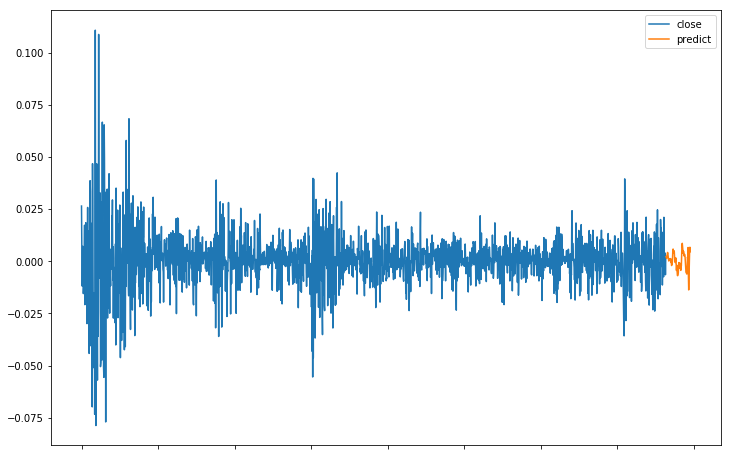

In [678]:
resid[['close', 'predict']].plot(figsize=(12, 8))

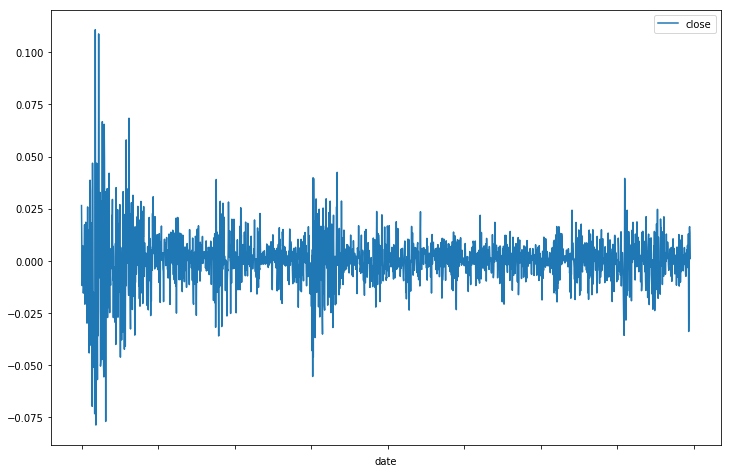

In [679]:
stock.plot(figsize=(12, 8))

In [680]:
from sklearn.metrics import confusion_matrix

In [681]:
endogenous_test

close
date                
2016-03-10 -0.000308
2016-03-11  0.012838
2016-03-14  0.000919
2016-03-15  0.001300
2016-03-16  0.004303
2016-03-17  0.008988
2016-03-18  0.006911
2016-03-21  0.001225
2016-03-22 -0.002343
2016-03-23 -0.004549
2016-03-24  0.000751
2016-03-28  0.001122
2016-03-29  0.005573
2016-03-30  0.004738
2016-03-31 -0.001782
2016-04-01  0.006088
2016-04-04 -0.003133
2016-04-05 -0.007537
2016-04-06  0.006404
2016-04-07 -0.009827
2016-04-08  0.001995
2016-04-11 -0.001169
2016-04-12  0.009389
2016-04-13  0.010554
2016-04-14  0.001014
2016-04-15 -0.001616
2016-04-18  0.005962
2016-04-19  0.002746
2016-04-20  0.002364
2016-04-21 -0.006286
...              ...
2016-05-20  0.003759
2016-05-23 -0.000458
2016-05-24  0.012183
2016-05-25  0.008215
2016-05-26 -0.001301
2016-05-27  0.002520
2016-05-31 -0.004813
2016-06-01  0.000139
2016-06-02  0.002748
2016-06-03 -0.001766
2016-06-06  0.006361
2016-06-07  0.001002
2016-06-08  0.003722
2016-06-09 -0.001103
2016-06-10 -0.006664
2016-06-13 -0.007437
2016-06-14 -0.003252
2016-06-15 -0.001960
2016-06-16  0.005268
2016-06-17 -0.003267
2016-06-20  0.007338
2016-06-21  0.001396
2016-06-22 -0.002743
2016-06-23  0.012949
2016-06-24 -0.033886
2016-06-27 -0.014971
2016-06-28  0.015722
2016-06-29  0.016368
2016-06-30  0.013298
2016-07-01  0.001081

[80 rows x 1 columns]

In [682]:
predicted.columns = ['predicted']

In [683]:
predicted.head()

predicted
date                 
2016-03-10   0.002251
2016-03-11   0.001769
2016-03-14   0.001392
2016-03-15   0.002676
2016-03-16   0.003499

In [684]:
endogenous_test['close'] = endogenous_test['close'].apply(lambda x: 0 if x<0 else 1)

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [685]:
endogenous_test

close
date             
2016-03-10      0
2016-03-11      1
2016-03-14      1
2016-03-15      1
2016-03-16      1
2016-03-17      1
2016-03-18      1
2016-03-21      1
2016-03-22      0
2016-03-23      0
2016-03-24      1
2016-03-28      1
2016-03-29      1
2016-03-30      1
2016-03-31      0
2016-04-01      1
2016-04-04      0
2016-04-05      0
2016-04-06      1
2016-04-07      0
2016-04-08      1
2016-04-11      0
2016-04-12      1
2016-04-13      1
2016-04-14      1
2016-04-15      0
2016-04-18      1
2016-04-19      1
2016-04-20      1
2016-04-21      0
...           ...
2016-05-20      1
2016-05-23      0
2016-05-24      1
2016-05-25      1
2016-05-26      0
2016-05-27      1
2016-05-31      0
2016-06-01      1
2016-06-02      1
2016-06-03      0
2016-06-06      1
2016-06-07      1
2016-06-08      1
2016-06-09      0
2016-06-10      0
2016-06-13      0
2016-06-14      0
2016-06-15      0
2016-06-16      1
2016-06-17      0
2016-06-20      1
2016-06-21      1
2016-06-22      0
2016-06-23      1
2016-06-24      0
2016-06-27      0
2016-06-28      1
2016-06-29      1
2016-06-30      1
2016-07-01      1

[80 rows x 1 columns]

In [686]:
predicted['predicted'] = predicted['predicted'].apply(lambda x: 0 if x<0 else 1)

In [687]:
residual = pd.concat([endogenous_test, predicted], axis=1, sort=False)

In [688]:
residual

close  predicted
date                        
2016-03-10      0          1
2016-03-11      1          1
2016-03-14      1          1
2016-03-15      1          1
2016-03-16      1          1
2016-03-17      1          1
2016-03-18      1          1
2016-03-21      1          1
2016-03-22      0          1
2016-03-23      0          1
2016-03-24      1          1
2016-03-28      1          1
2016-03-29      1          1
2016-03-30      1          1
2016-03-31      0          1
2016-04-01      1          1
2016-04-04      0          0
2016-04-05      0          0
2016-04-06      1          0
2016-04-07      0          0
2016-04-08      1          0
2016-04-11      0          1
2016-04-12      1          1
2016-04-13      1          1
2016-04-14      1          1
2016-04-15      0          1
2016-04-18      1          1
2016-04-19      1          1
2016-04-20      1          1
2016-04-21      0          1
...           ...        ...
2016-05-20      1          0
2016-05-23      0          1
2016-05-24      1          1
2016-05-25      1          1
2016-05-26      0          1
2016-05-27      1          1
2016-05-31      0          1
2016-06-01      1          1
2016-06-02      1          1
2016-06-03      0          1
2016-06-06      1          1
2016-06-07      1          1
2016-06-08      1          1
2016-06-09      0          0
2016-06-10      0          0
2016-06-13      0          0
2016-06-14      0          0
2016-06-15      0          0
2016-06-16      1          0
2016-06-17      0          0
2016-06-20      1          1
2016-06-21      1          1
2016-06-22      0          1
2016-06-23      1          0
2016-06-24      0          0
2016-06-27      0          0
2016-06-28      1          0
2016-06-29      1          1
2016-06-30      1          1
2016-07-01      1          1

[80 rows x 2 columns]

In [689]:
conf_mat = confusion_matrix(residual['predicted'], residual['close'])
acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
print('Overall accuracy: {} %'.format(acc*100))

Overall accuracy: 66.25 %


In [717]:
print('Baseline accuracy: {} %'.format(residual['close'].mean()*100))

Baseline accuracy: 57.49999999999999 %


## Plotly Graph

In [698]:
resid.tail()

close   predict
2016-06-27    NaN -0.006979
2016-06-28    NaN -0.000213
2016-06-29    NaN  0.004932
2016-06-30    NaN  0.006745
2016-07-01    NaN  0.004615

In [705]:
plotly.tools.set_credentials_file(username='augustinechang1', api_key='RMoxbU48hbhCLMPhDNX7')

In [712]:
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv")

trace_high = go.Scatter(
                x=stock.index,
                y=stock['close'],
                name = "Actual",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_low = go.Scatter(
                x=resid.index,
                y=resid['predict'],
                name = "Predicted",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)

data = [trace_high,trace_low]

layout = dict(
    title = "Dow Jones % Change in Price Forecast",
    xaxis = dict(
        range = ['2008-08-08','2016-07-01'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Manually Set Range")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~augustinechang1/0 or inside your plot.ly account where it is named 'Manually Set Range'


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [85]:
#save file for web app
stock.to_csv(r'/Users/flatironschool/Final Project/stockchange.csv')

In [87]:
resid.to_csv(r'/Users/flatironschool/Final Project/predicted.csv')

In [88]:
resid.head()

close  predict
2008-08-08  0.026496      NaN
2008-08-11  0.004093      NaN
2008-08-12 -0.011872      NaN
2008-08-13 -0.009406      NaN
2008-08-14  0.007194      NaN

In [745]:
# fit model
full_mod = ARIMA(stock, order=(0,0,2), exog = indicators)
full_results = full_mod.fit()
print(full_results.summary())

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1989
Model:                     ARMA(0, 2)   Log Likelihood                6104.342
Method:                       css-mle   S.D. of innovations              0.011
Date:                Wed, 06 Feb 2019   AIC                         -12188.684
Time:                        16:28:33   BIC                         -12132.730
Sample:                             0   HQIC                        -12168.133
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0015      0.000      4.255      0.000       0.001       0.002
EMA         -6.469e-09        nan        nan        nan         nan         nan
MACD_Hist   -5.919e-06   5.77e-06     -1.026    

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning:

invalid value encountered in sqrt

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning:

invalid value encountered in less_equal



In [756]:
stock.head()

close
date                
2008-08-08  0.026496
2008-08-11  0.004093
2008-08-12 -0.011872
2008-08-13 -0.009406
2008-08-14  0.007194

In [757]:
full_predicted.head()

predicted
date                 
2008-08-08   0.003230
2008-08-11   0.001675
2008-08-12  -0.002718
2008-08-13   0.000613
2008-08-14   0.002445

In [755]:
full_predicted = pd.DataFrame(full_results.predict(start = 0,
                                    end = 1988,
                                    exog = indicators,
                                    dynamic = True))
full_predicted.columns = ['predicted']

In [758]:
full_predicted['residual'] = full_predicted['predicted'] - stock['close']

In [762]:
full_residual = full_predicted.drop(['predicted'], axis=1)

In [862]:
full_residual['residual']

date
2008-08-08   -0.023266
2008-08-11   -0.002418
2008-08-12    0.009154
2008-08-13    0.010019
2008-08-14   -0.004749
2008-08-15   -0.005520
2008-08-18    0.009056
2008-08-19    0.005765
2008-08-20   -0.010766
2008-08-21   -0.000848
2008-08-22   -0.021032
2008-08-25    0.014661
2008-08-26   -0.004145
2008-08-27   -0.003616
2008-08-28   -0.016118
2008-08-29    0.016445
2008-09-02    0.000315
2008-09-03   -0.006762
2008-09-04    0.022440
2008-09-05   -0.000612
2008-09-08   -0.026001
2008-09-09    0.017866
2008-09-10   -0.007846
2008-09-11   -0.016420
2008-09-12   -0.009507
2008-09-15    0.032472
2008-09-16   -0.025412
2008-09-17    0.033353
2008-09-18   -0.036296
2008-09-19   -0.034087
                ...   
2016-05-20   -0.005770
2016-05-23    0.003678
2016-05-24   -0.002123
2016-05-25    0.002372
2016-05-26    0.009414
2016-05-27    0.003929
2016-05-31    0.009534
2016-06-01    0.005831
2016-06-02    0.002455
2016-06-03    0.004698
2016-06-06   -0.002572
2016-06-07    0.002834
2016-0

In [867]:
!pip install dash

  Using cached https://files.pythonhosted.org/packages/0e/2a/378bd072928f6d92fd8c417d66b00c757dc361c0405a46a0134de6fd323d/Flask-Compress-1.4.0.tar.gz
    100% |████████████████████████████████| 942kB 1.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for dash ... done
  Stored in directory: /Users/flatironschool/Library/Caches/pip/wheels/fc/e7/af/d0b551efefa68836b2792b86b3105dabac3b44136db3a6827a
  Running setup.py bdist_wheel for flask-compress ... done
  Stored in directory: /Users/flatironschool/Library/Caches/pip/wheels/96/32/88/a1f6d9dd3c29570ab3a8acc0d556b3b20abcf3c623c868ce0a
  Running setup.py bdist_wheel for dash-renderer ... done
  Stored in directory: /Users/flatironschool/Library/Caches/pip/wheels/09/d2/49/0d140766d5ee1ef4ce271d302a5d30cf3d18c5b507e48c77f3
Successfully built dash flask-compress dash-renderer


In [764]:
full_residual.to_csv(r'/Users/flatironschool/Final Project/full_residual.csv')

In [868]:
import dash

In [869]:
app = dash.Dash(__name__)
server = app.server

In [870]:
if __name__ == '__main__':
	app.run_server(debug=True)

Running on http://127.0.0.1:8050/
Debugger PIN: 039-563-499
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.

